<a href="https://colab.research.google.com/github/naldo14/tesis-/blob/main/BBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## importo las librerias
import h5py
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow import keras
tfd = tfp.distributions
tfpl = tfp.layers

In [2]:
## hago el mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Proceso de carga de los datos

## data sobre el eje y

In [3]:
#creo el h5py de las features
path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/features_y"
hdf5_file_path = path_features
with h5py.File(hdf5_file_path, 'r') as hf:
    y_features = hf['features_y'][:]


In [4]:

path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/y_targets"
hdf5_file_path = path_features
with h5py.File(hdf5_file_path, 'r') as hf:
    y_targets = hf['y_targets'][:]

In [ ]:
y_targets.shape

(55,)

### data sobre el eje *x*

In [58]:
#creo el h5py de las features
path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/features_x"
hdf5_file_path = path_features
with h5py.File(hdf5_file_path, 'r') as hf:
   x_features = hf['features_x'][:]


In [59]:
path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/x_targets"
hdf5_file_path = path_features
with h5py.File(hdf5_file_path, 'r') as hf:
    x_targets = hf['x_targets'][:]

In [6]:
## data sets but using y-axis measures
from sklearn.model_selection import train_test_split
# Assuming x is your dataset with shape (70, 14) and y is your labels
x_train, x_test, y_train, y_test = train_test_split(y_features, y_targets, test_size=0.3, random_state=42)



In [69]:
## data sets but using x-axis measures
from sklearn.model_selection import train_test_split
# Assuming x is your dataset with shape (70, 14) and y is your labels
x_train, x_test, y_train, y_test = train_test_split(x_features, x_targets, test_size=0.3, random_state=42)


### Creacion de la BNN

In [7]:
## def prior weight distribution N(1,0) and not trainable
# Define the prior weight distribution N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

In [8]:
# Define the posterior weight distribution Multivariate Gaussian distribution
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [102]:
# Define the BNN model
model = tf.keras.Sequential([
    tfpl.DenseVariational(
        input_shape=(14,),
        units=20,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        kl_weight=1/x_train.shape[0],  # KL Weight
        # kl_use_exact=True
    ),

       tfpl.DenseVariational(
        units=15,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),

    tfpl.DenseVariational(
        units=10,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),

    tfpl.DenseVariational(
        units=5,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),


      tfpl.DenseVariational(
        units=1,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='sigmoid',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    # tfpl.DenseVariational(
    #     units=10,
    #     make_prior_fn=prior,
    #     make_posterior_fn=posterior,
    #     activation='relu',
    #     use_bias=True,
    #     kl_weight=1/x_train.shape[0]  # KL Weight
    # ),
    # tfpl.DenseVariational(
    #     units=7,
    #     make_prior_fn=prior,
    #     make_posterior_fn=posterior,
    #     activation='relu',
    #     use_bias=True,
    #     kl_weight=1/x_train.shape[0]  # KL Weight
    # ),
    # tfpl.DenseVariational(
    #     units=1,
    #     make_prior_fn=prior,
    #     make_posterior_fn=posterior,
    #     activation='linear',
    #     use_bias=True,
    #     kl_weight=1/x_train.shape[0]  # KL Weight
    # ),
])

In [101]:
del model

NameError: ignored

In [103]:

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_107 (Den  (None, 20)                45450     
 seVariational)                                                  
                                                                 
 dense_variational_108 (Den  (None, 15)                50085     
 seVariational)                                                  
                                                                 
 dense_variational_109 (Den  (None, 10)                13040     
 seVariational)                                                  
                                                                 
 dense_variational_110 (Den  (None, 5)                 1595      
 seVariational)                                                  
                                                                 
 dense_variational_111 (Den  (None, 1)               

In [104]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

# Train the model
history = model.fit(x_train, y_train, epochs=1000, verbose=2)

# Evaluate the model on the test data
test_loss, test_accuracy, false_negatives, false_positives = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"False Negatives: {false_negatives:.0f}")
print(f"False Positives: {false_positives:.0f}")

# Make predictions on test data
y_pred = model.predict(x_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(confusion)


Epoch 1/1000
2/2 - 3s - loss: 4.0036 - accuracy: 0.3750 - false_negatives_15: 30.0000 - false_positives_15: 0.0000e+00 - 3s/epoch - 2s/step
Epoch 2/1000
2/2 - 0s - loss: 6.3516 - accuracy: 0.3750 - false_negatives_15: 23.0000 - false_positives_15: 7.0000 - 16ms/epoch - 8ms/step
Epoch 3/1000
2/2 - 0s - loss: 2.5008 - accuracy: 0.6250 - false_negatives_15: 9.0000 - false_positives_15: 9.0000 - 16ms/epoch - 8ms/step
Epoch 4/1000
2/2 - 0s - loss: 4.3178 - accuracy: 0.5417 - false_negatives_15: 11.0000 - false_positives_15: 11.0000 - 16ms/epoch - 8ms/step
Epoch 5/1000
2/2 - 0s - loss: 2.5941 - accuracy: 0.6667 - false_negatives_15: 15.0000 - false_positives_15: 1.0000 - 16ms/epoch - 8ms/step
Epoch 6/1000
2/2 - 0s - loss: 9.3648 - accuracy: 0.3333 - false_negatives_15: 32.0000 - false_positives_15: 0.0000e+00 - 20ms/epoch - 10ms/step
Epoch 7/1000
2/2 - 0s - loss: 3.2503 - accuracy: 0.3750 - false_negatives_15: 23.0000 - false_positives_15: 7.0000 - 19ms/epoch - 10ms/step
Epoch 8/1000
2/2 - 0

1/1 [==============================] - 0s 26ms/step


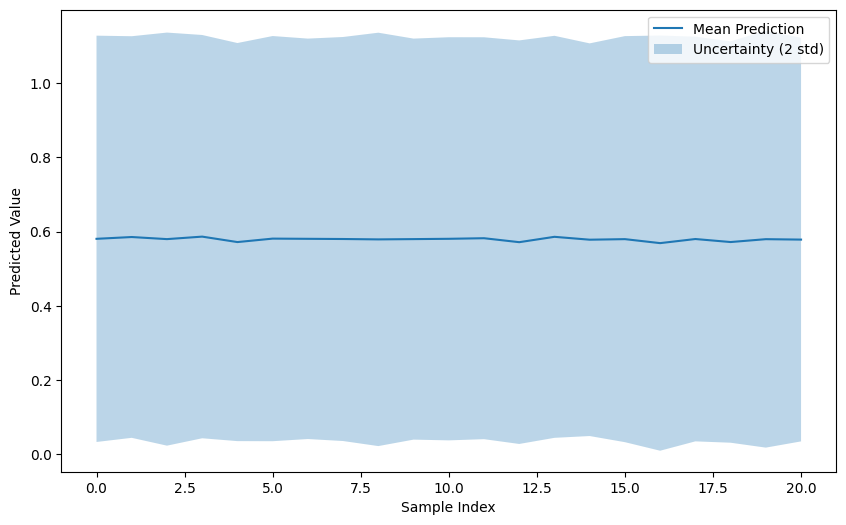

In [105]:
# Visualize uncertainty by plotting predictive distribution
n_samples = 100  # Number of samples to draw
predictions = []

for _ in range(n_samples):
    y_pred_sample = model.predict(x_test)
    predictions.append(y_pred_sample)

# Calculate mean and standard deviation of predictions
predictions = np.array(predictions)
mean_prediction = predictions.mean(axis=0)
std_prediction = predictions.std(axis=0)

mean_prediction = mean_prediction.ravel()
std_prediction = std_prediction.ravel()

# Plot mean prediction and uncertainty
plt.figure(figsize=(10, 6))
plt.plot(mean_prediction, label='Mean Prediction')
plt.fill_between(
    range(len(mean_prediction)),
    mean_prediction - 2 * std_prediction,
    mean_prediction + 2 * std_prediction,
    alpha=0.3,
    label='Uncertainty (2 std)'
)
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend()
plt.show()


In [107]:
test_accuracy


0.7142857313156128

In [119]:
y_pred_1= model.predict(x_test)


1/1 [==============================] - 0s 21ms/step


In [121]:
y_pred_sample

array([[0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005],
       [0.7247005]], dtype=float32)

In [128]:
predictions[4]

array([[0.11720247],
       [0.16540512],
       [0.51478285],
       [0.15572831],
       [0.2750347 ],
       [0.12151583],
       [0.12925945],
       [0.11682504],
       [0.51478285],
       [0.12984414],
       [0.11691392],
       [0.11985599],
       [0.17203902],
       [0.14999112],
       [0.14990951],
       [0.11269102],
       [0.14841259],
       [0.11557615],
       [0.19451186],
       [0.12666811],
       [0.13666409]], dtype=float32)

In [115]:
x_test.shape

(21, 14)

In [116]:
y_pred_1.shape

(21, 1)